In [2]:
from kubernetes import client, config
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
config.load_kube_config()
graph_dir = "graphs/"

In [4]:
stats_name = ['msg rcv total',
              'msg sent total',
              'comp time per iter',
              'xchg time per iter',
              'avg time per iter',
              'total time',
              'total iter']

In [44]:
def read_metrics():
    metrics = {}

    v1 = client.CoreV1Api()
    ret = v1.list_pod_for_all_namespaces(watch=False)
    for i in ret.items:
        if i.metadata.name.startswith("my-scheduler-") or i.metadata.name.startswith("my-controller"):
            # print(f"{i.metadata.name} {i.status.pod_ip}")
            lines = v1.read_namespaced_pod_log(
                name=i.metadata.name, namespace=i.metadata.namespace)

            name = i.metadata.name
            if name.startswith('my-scheduler-'):
                metrics[name] = {}
            for line in lines.split('\n'):
                if name.startswith('my-sched') and line.startswith('{'):
                    d = json.loads(line)
                    for sn in stats_name:
                        if sn.endswith('per iter'):
                            if not sn in metrics[name]:
                                metrics[name][sn] = []
                            if sn in d:
                                metrics[name][sn].append(d[sn])
                        else:
                            if sn in d:
                                metrics[name][sn] = d[sn]
    return metrics

In [43]:
p = 9
with open(f'data/data-{p}pods.json', 'r') as f:
  for line in f:
    metrics = json.loads(line)

In [44]:
print(len(metrics))

9


## stats per pod

Plot stats, large variance in computation time per iteration is perhaps due to the
short period of computation leading to incorrect timing measurement

8.540851085987104
5.2536756688285395
5.707770105865308
9.299172413261326
6.502266574536945
7.217885858727708
7.06327206398869
6.198670416119094
5.744964473795362
441.5925521885003
417.53719366638273
360.9387404977757
389.0745710694517
306.0131681727213
313.5148145384153
410.0654257942568
355.36436072068574
349.0182564073583
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


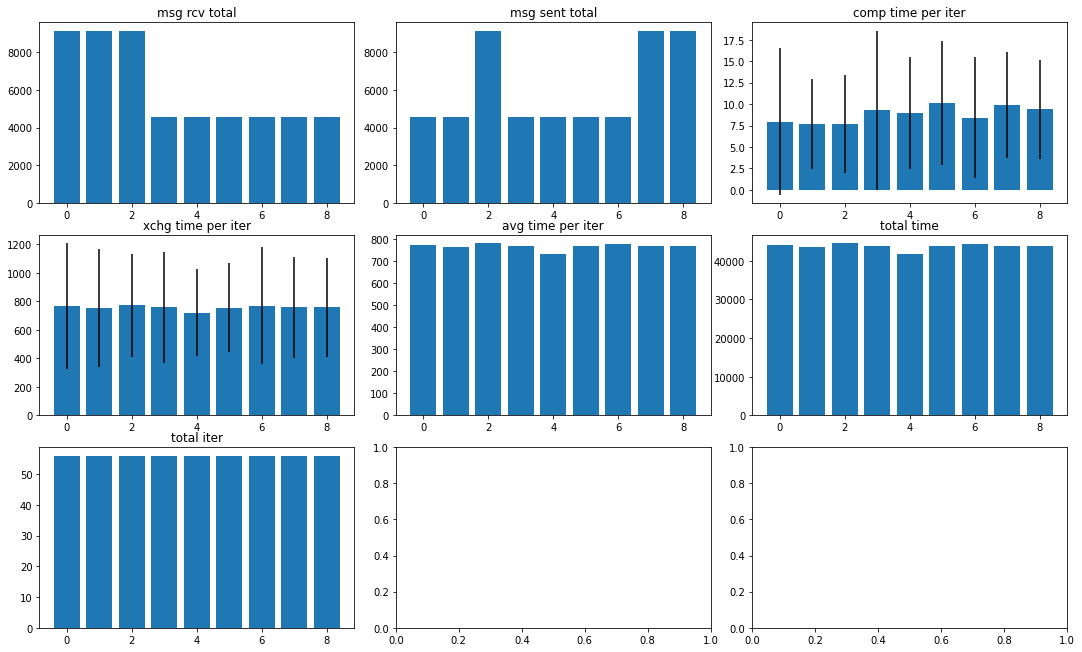

In [45]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 9)
fig.tight_layout()

x = range(len(metrics.keys()))


for i, sn in enumerate(stats_name):
    y = []
    if sn.find('total') != -1:
        for name in metrics:
            y.append(metrics[name][sn])
        a = ax[i // 3][i % 3]
        a.bar(x, y)
        a.set_title(sn)

    elif sn.find('per iter') != -1:
        for name in metrics:
            d = np.array(metrics[name][sn])
            mean = np.mean(d)
            std = np.std(d)
            print(std)
            y.append([mean, std])
        y = np.array(y)
        a = ax[i // 3][i % 3]
        a.bar(x, y[:, 0], yerr = y[:, 1])
        a.set_title(sn)

fig.savefig(f'{graph_dir}metrics-{p}pods.png')
fig.savefig(f'{graph_dir}metrics-{p}pods.pdf')

## Stats against number of pods

In [5]:
pods = [9, 50, 100, 150, 200]
p = pods[0]
metrics = {}
for p in pods:
    with open(f'data/data-{p}pods.json', 'r') as f:
        for line in f:
            metrics[p] = json.loads(line)

54744
729513
1910180
4304956
7648412


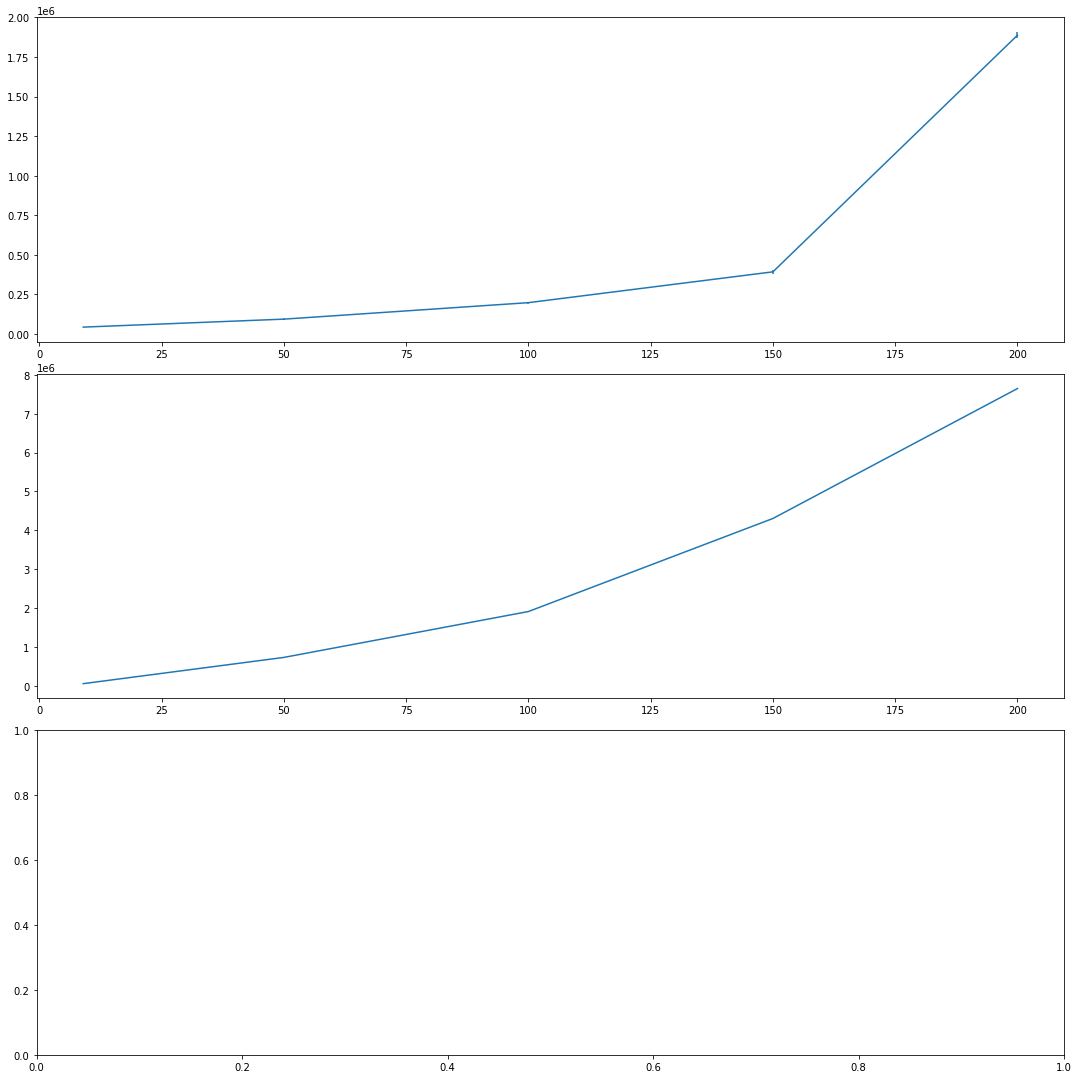

In [17]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(15, 15)
fig.tight_layout()

x = pods
y_time = []
y_msg_sent = []
y_msg_rcv = []

for p in pods:
  tmp = np.array([metrics[p][name]['total time'] for name in metrics[p]])

  y_time.append([np.mean(tmp), np.std(tmp)])

  tmp = np.array([metrics[p][name]['msg sent total'] for name in metrics[p]])
  y_msg_sent.append(np.sum(tmp))
  print(sum(tmp))

  tmp = np.array([metrics[p][name]['msg rcv total'] for name in metrics[p]])
  y_msg_rcv.append(np.sum(tmp))
  
y_time = np.array(y_time)
y_msg_sent = np.array(y_msg_sent)
y_msg_rcv = np.array(y_msg_rcv)


ax[0].errorbar(x, y_time[:, 0], yerr = y_time[:, 1])
ax[1].plot(x, y_msg_sent)